## Group Contributions Statement: 
All three of us wrote the data acquisition and preparation. Ameen led Figure 2(Box Plot) and the K-Nearest Neighbor model.
Thuy led Figure 1 (Bar Chart), the Summary Table and the random forest model. Ernest led Figure 3 (Scatter plot), the Correlation Table, and the Multinomial logistic regression model. 
We all wrote the explanation of our own respective models mentioned earlier. Ernest wrote the conclusion discussion. The group worked together collaboratively to double check each other's code and make sure everything was running smoothly.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score


In [4]:
penguins = pd.read_csv("palmer_penguins.csv")

In [6]:
# prepping function; for cleaning X train/ y train
def prep_data(og_df, target, predictors):
    '''
    Input:
    > dataset
    > target = col name of target var (string)
    - split and clean data set
    - transform qualitative values into numerical

    After making a copy of the original dataframe, "og_df", the function uses LabelEncoder() 
    to map all of the categorical variables in the penguins dataset to numerical values to 
    digitally represent every factor so that it can be processed into the models. Afterwards, 
    all the rows with NaN values are dropped before subsetting the data set into the predictor
    dataframe X and the target variable y. 

    Output: df X for predictor var and df y for target var
    '''
    le = LabelEncoder()

    df = og_df.copy()

    # Transform the target variable if it's categorical
    if isinstance(df[target].dtype, object):
        df[target] = le.fit_transform(df[target])

    # Loop through all columns and transform if categorical
    for name in df.columns:
        if isinstance(df[name].dtype, object):
            df[name] = le.fit_transform(df[name])

    # Drop rows with missing values
    df = df.dropna()

    # Separate predictors and target
    X = df.drop(target, axis=1)  # Drop target from predictors
    X = X[predictors]
    y = df[target]  # Target variable

    return X, y

## Exploratory Analysis:
    

**Table summary function:**

To better understand the dataframe and differences between the species, we will summarize it using a table. The table will display the average value of different variables for each species, which will serve as a representation of what an average penguin from each species look like

In [20]:
# simplify species name
penguins['Species'] = penguins['Species'].apply(lambda x: x.split(' ')[0])

def penguin_summary_table(group_cols, value_cols):
    '''
    Input: 
    > group_cols: List of names of variables of the penguins dataframe to group the data frame by 
    > value_cols: List of names of variables of the penguins dataframe to compute the mean 

    This function groups the penguins dataset by the variables that are in the group_cols list 
    argument. Then the function computs the mean of each group with regards to the the columns that 
    are in the value_cols argument. 

    Output: Data frame of the mean of each variable (from value_cols) with respect to each subgroup
    (with respect to group_cols)
    '''
    return penguins.groupby(group_cols)[value_cols].aggregate('mean').round(2)


quant_var = penguin_summary_table(['Species'],['Body Mass (g)', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)'])

quant_var

,Body Mass (g),Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo)
Species,,,,,,
Adelie,3700.66,38.79,18.35,189.95,8.86,-25.80
Chinstrap,3733.09,48.83,18.42,195.82,9.36,-24.55
Gentoo,5076.02,47.50,14.98,217.19,8.25,-26.19


**Bar plot:**

From the table, we can create a bar plot to better visualize these numbers.

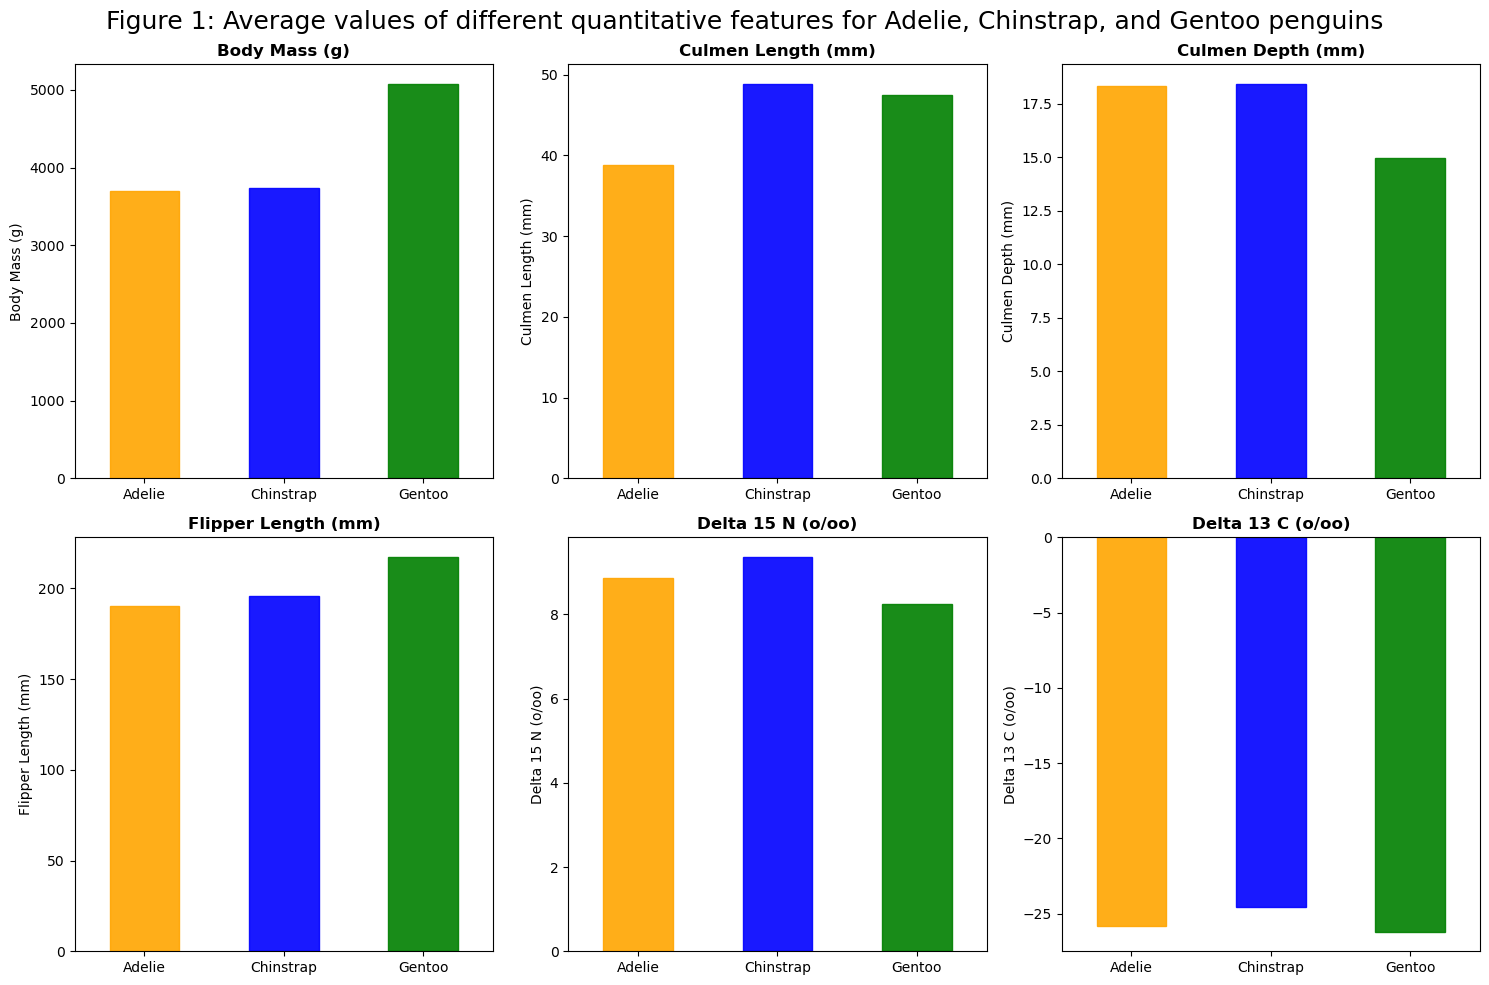

In [35]:
## creating bar plot

fig, ax = plt.subplots(2,3, figsize = (15,10))
quant_var.plot(kind = 'bar', subplots = True, ax=ax, legend = None, alpha = 0.9)

y_labels = list(quant_var.columns)
species_colors = {'Adelie': 'orange', 'Chinstrap': 'blue', 'Gentoo': 'green'}

for i, axis in enumerate(ax.flatten()):
    axis.set_ylabel(y_labels[i])  # Set the y-axis label
    axis.set_xlabel(None)
    axis.set_title(quant_var.columns[i], weight='bold')
    axis.tick_params(axis='x', rotation=0)  # Rotate x-ticks horizontally (0 degrees)
    
    # coloring
    species = quant_var.index  
    color_map = [species_colors[sp] for sp in species]
    for bar, color in zip(axis.patches, color_map):
        bar.set_color(color)

fig.suptitle('Figure 1: Average values of different quantitative features for Adelie, Chinstrap, and Gentoo penguins', size=18)

plt.tight_layout()

**Analysis**: The bar plots show how each species differ in their average value of the 6 main quantitative features. From the bar plots, we can see that it is often the case that 2 species will have similar averages, and the third species would have a significantly different average value. For example, for body mass, Adelie and Chinstrap penguins have similar values, averaging around 3700g, whereas Gentoo's body mass is significantly higher, averaging around 5000g. We can use these differences to narrow the range of quantitative features of interest. 

Of all the quantitative variables, **body mass, culmen length, and culmen depth** display the greatest discrepancy between one species and the rest. For culmen depth, similar to body mass, Gentoo penguins have a significantly different average compared to the other 2 species. For culmen length, Chinstrap and Gentoo penguins both have a significantly higher average compared to Adelie penguins. This suggests that these variables can be used as predictors for species. We can narrow down to 2 variable with further explorations of the data.

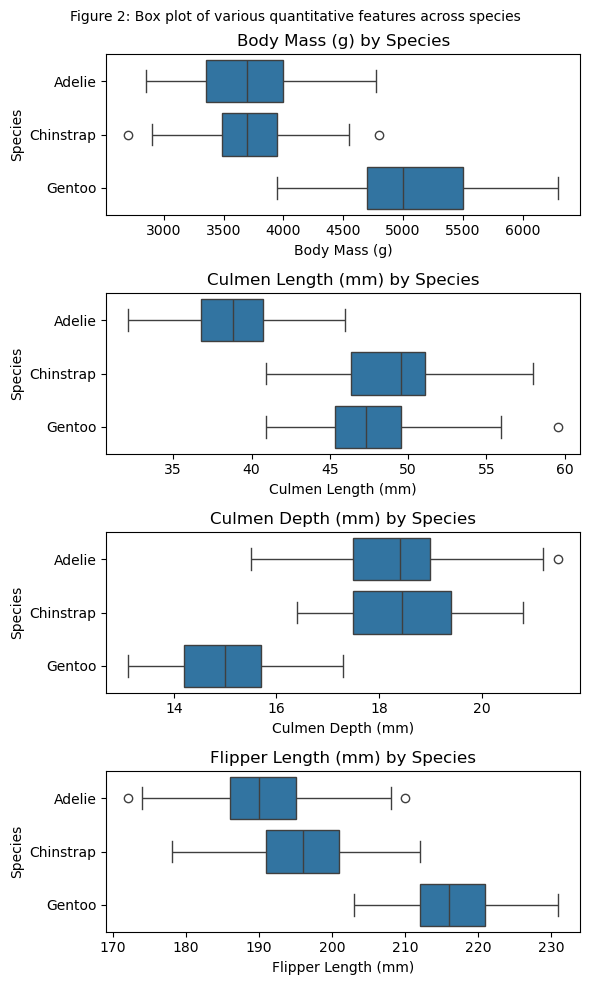

In [49]:
#EDA BOXPLOT
#Shows Box plot of all three species for each quantitative variable using seaborn
#Uses multiple axes 

# Select numerical and categorical variables
quant_vars = ["Body Mass (g)", "Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)"]
qual_var = "Species"

# Drop missing values
penguins1 = penguins.dropna(subset=quant_vars + [qual_var])

# Create subplots
fig, axes = plt.subplots(len(quant_vars), 1, figsize=(6, 10), sharex=False)

for i, var in enumerate(quant_vars):
    sns.boxplot(y=qual_var, x=var, data=penguins1, ax=axes[i], orient="h")
    axes[i].set_title(f"{var} by {qual_var}")
    axes[i].set_ylabel(qual_var)
    axes[i].set_xlabel(var)

fig.suptitle("Figure 2: Box plot of various quantitative features across species", size = 10)


plt.tight_layout()
plt.show()

**Analysis:** This box plot compares the significant numerical data amongst each of the three species types. It is a good reference for our feature selection of our quantitative variables since it shows a distinction of important statistics for each category. Our features, Culmen Depth and Culmen Length, each have one species with a significant difference from the other two. This is helpful to our models because when looking at a certain species, we can easily see the distinctiveness in the features compared to the other species. This makes the accuracy for that variable higher in our model. Since the distinct features belong to different species for culmen depth and culmen length, it makes it even easier to detect when we separate the species by island.


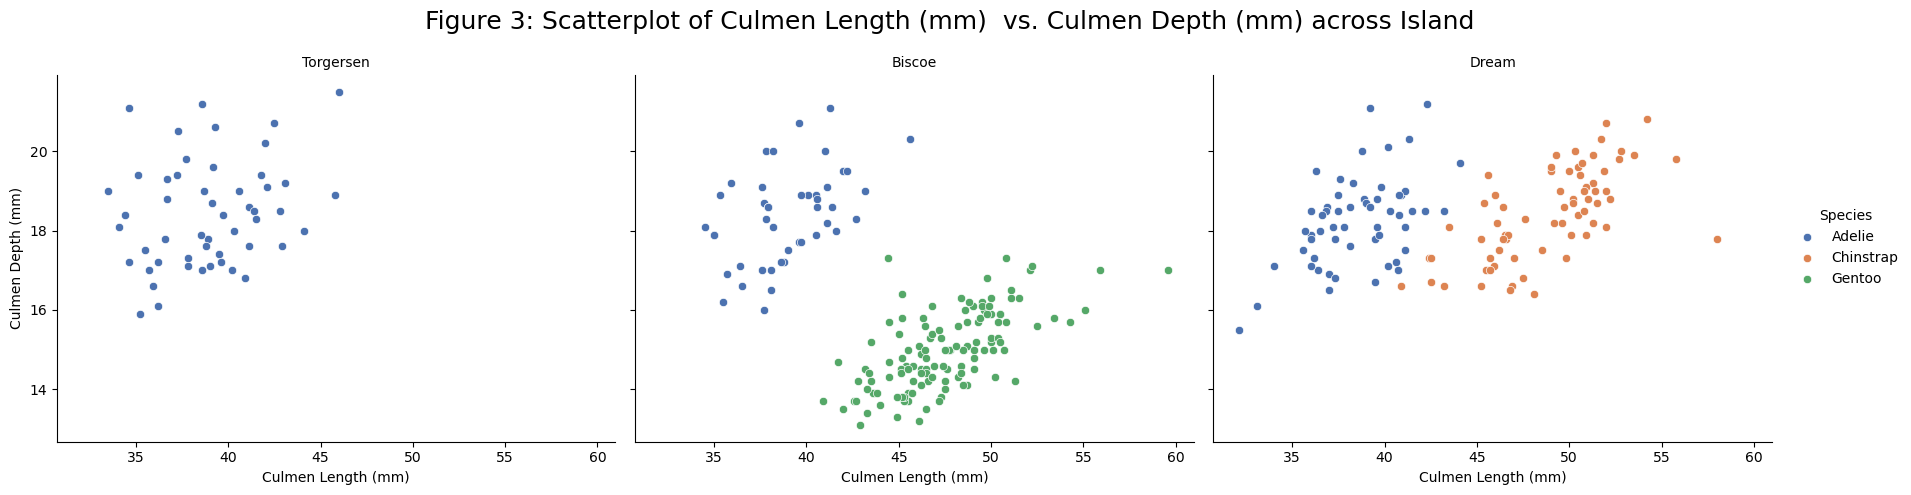

In [54]:
# EDA Scatter plot
g = sns.FacetGrid(penguins, col="Island", hue="Species", height=5, aspect=1.2, palette="deep")
g.map_dataframe(sns.scatterplot, x="Culmen Length (mm)", y="Culmen Depth (mm)")

# Add legends and labels
g.set_axis_labels("Culmen Length (mm)", "Culmen Depth (mm)")
g.set_titles(col_template="{col_name}")  # Each subplot title is the Island name
g.add_legend()

g.fig.suptitle("Figure 3: Scatterplot of Culmen Length (mm)  vs. Culmen Depth (mm) across Island", size = 18)
plt.subplots_adjust(top=0.85) 

# Show plot
plt.show()

**Analysis:** The code above generates a scatter plot of the two numerical variables - Culmen Depth (mm) and Culmen Length (mm) - across the there factors of the quantitative variable, Island, colored by the Species variable, the response variable. In order to show that the features that we have selected would be useful in predicting the Species of each observation, it is crucial to see great amount of distinction between clusters of data points of the same Species and as little overlap as possible. While there is only Adelie Penguin on Togersen, there are at least two distinct specie groups on Biscoe and Dream. From analyazing those plots, we can see a great deal of separation, especially for Biscoe. The distinction indicates that the selected features would contribute to significant variance in predicting the species, hence, justifying our feature selection.  

In [72]:
label_encoder = LabelEncoder()

def cor_matrix(df, variable):
    '''
    Input: 
    > df: the data frame to find the correlation coefficients for 
    > variable: the variable to find the correlation matrix for

    This function first makes a copy of the input data frame. Then it selects all the categorical 
    variables and maps the categorical data to distinct digital factors. Afterwards, it finds the 
    correlation matrices for the dataframe and returns the one for the variable input.

    Output: Correlation matrix of the input dataframe with respect to the input variable name.
    '''

    new_df = df.copy()

    # Select categorical columns
    cat_cols = new_df.select_dtypes(include=['object', 'category']).columns

    # Encode categorical columns
    for col in cat_cols:
        new_df[col] = label_encoder.fit_transform(new_df[col])

    # Compute correlation matrix
    corr_matrix = new_df.corr()
    corr_table = corr_matrix[variable]
    
    print(corr_table)

cor_matrix(penguins, "Species")


studyName              0.035150
Sample Number         -0.170305
Species                1.000000
Region                      NaN
Island                -0.635659
Stage                       NaN
Individual ID         -0.152269
Clutch Completion      0.032682
Date Egg               0.451204
Culmen Length (mm)     0.731369
Culmen Depth (mm)     -0.744076
Flipper Length (mm)    0.854307
Body Mass (g)          0.750491
Sex                   -0.010379
Delta 15 N (o/oo)     -0.477606
Delta 13 C (o/oo)     -0.189595
Comments               0.270393
Name: Species, dtype: float64


In [66]:
cor_matrix(penguins, "Culmen Length (mm)")

studyName              0.054545
Sample Number         -0.236356
Species                0.731369
Region                      NaN
Island                -0.353647
Stage                       NaN
Individual ID          0.091148
Clutch Completion     -0.040227
Date Egg               0.309623
Culmen Length (mm)     1.000000
Culmen Depth (mm)     -0.235053
Flipper Length (mm)    0.656181
Body Mass (g)          0.595110
Sex                    0.269434
Delta 15 N (o/oo)     -0.059759
Delta 13 C (o/oo)      0.189025
Comments               0.241288
Name: Culmen Length (mm), dtype: float64


# Feature Selection Summary

**Categorical Choice:**  *Island*
<br>
Reasoning:

*   Each Island only includes two different species at max and the torgersen island has only Adelie penguins which gives the models clear direction on that island.

*  We see this clearly through the **summary table**, which explicitly shows the sets of species that belong to each island respectively.



**Numerical Choices:** *Culmen Length (mm), Culmen Depth(mm)*
<br>
Reasoning:

*  Culmen Length seems like the best feature to pair with Island since the most distinct culmen length belongs to the Adelie species. This is shown in the summary plots and all of the exploratory data analysis plots (box plot, histogram, scatter plot)
*   This works well with Island since Adelie penguins are the only species that reside on all three islands so we are always comparing with Adelie.

*  Culmen Depth was our next choice due to its surprisingly low correlation to Culmen Length as seen from the **Correlation Plot** with respect to Culmen Length. Furthermore, Culmen Depth has a strong negative relationship with Species, making it an ideal predictor variable.
  
* Correlation plays a significant role in our feature selection. This is because if the correlation is too high between  two features then it makes our data redundant and does not add any information to the broader data set.


## Modeling:

In [76]:
# DECISION REGION FUNCTION

def plot_regions(c, X, y, features):
    '''

    input:
    - c: model used for prediction
    - X: a dataframe of the predictor data
    - y: target data
    - features: list of selected predictor features

    This function plots the decision regions for each island. The function first plots the shaded predicted region and decions boundaries that
    shows the model's guess of the characteristic ranges of features for each species. The function then plots the actual data that shows each individual
    penguins as a scatter points on top of the predicted regions.

    output: a figure with 3 subplots showing the decision regions, each corresponding to an island


    '''
    # create subplots
    fig, ax = plt.subplots(1,3, figsize = (15, 5))

    island = list(set(X['Island']))

    for i in range(len(island)):

        feature_1, feature_2 = features

        # extract feature columns
        x0 = X[X['Island'] == island[i]][feature_1]
        x1 = X[X['Island'] == island[i]][feature_2]

        # create grid for visualization
        grid_x = np.linspace(x0.min(), x0.max(), 501)
        grid_y = np.linspace(x1.min(), x1.max(), 501)
        xx, yy = np.meshgrid(grid_x, grid_y)

        # prep data for model prediction
        XX = xx.ravel() # flattens xx coordinates into a 1D array
        YY = yy.ravel()
        XY = pd.DataFrame({ feature_1 : XX,
                           feature_2 : YY,
                          'Island' : island[i]}) ## create a 1d array of that 1 island

        # model prediction
        p = c.predict(XY)
        p = p.reshape(xx.shape) # reshaped to match the 2D grid shape for visualization


        # plotting the decision boundaries on the predicted regions
        ax[i].contourf(xx, yy, p, cmap = 'jet', alpha = 0.2, vmin = 0, vmax = 2)
        # plotting the original data points
        ax[i].scatter(x0, x1, c = y[X['Island'] == island[i]], cmap = 'jet', vmin = 0, vmax = 2)

        #gives title to plot rather than 0, 1, and 2
        island_map = {0: "Biscoe",
                   1: "Dream" ,
                   2: "Torgersen"}

        # setting the axis
        ax[i].set(xlabel = feature_1, ylabel = feature_2, title = island_map[i])

    # *****LEGEND********
    import matplotlib.patches as mpatches

    species_mapping = {0: "Adelie", 1: "Chinstrap", 2: "Gentoo"}
    species_colors = {0: "blue", 1: "green", 2: "red"}

    # Generate legend patches
    patches = [mpatches.Patch(color=species_colors[val], label=species) for val, species in species_mapping.items()]

    # Add legend to the figure
    fig.legend(handles=patches, title="Species", loc="upper right")

    plt.show()



## K-Nearest Neighbors Model

5


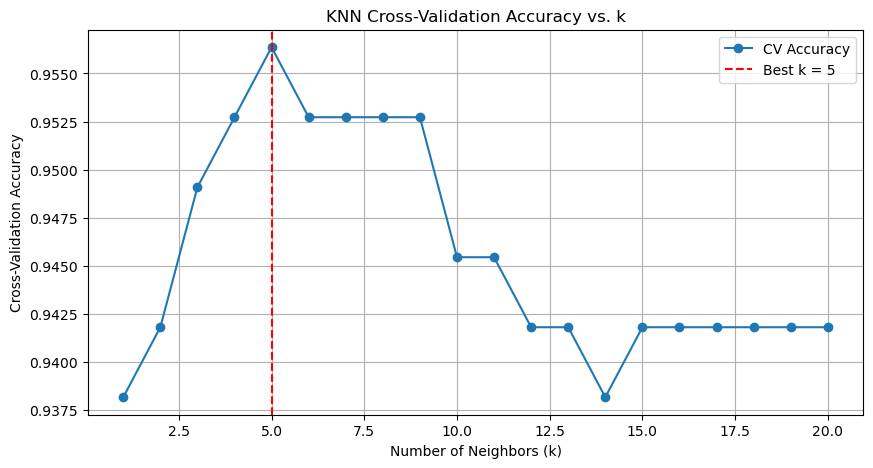

In [78]:
#Apply function to KNN model
from sklearn.neighbors import KNeighborsClassifier

X,y = prep_data(penguins, 'Species', ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Island'])
features = ['Culmen Depth (mm)', 'Culmen Length (mm)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

k_values = range(1, 21)  # Test k from 1 to 20
scores = []

#5-fold Cross validation to find best k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(cv_scores.mean())

# Find the best k
best_k = k_values[np.argmax(scores)]
print(best_k)

# ** Add Cross-Validation Plot Here **
plt.figure(figsize=(10, 5))
plt.plot(k_values, scores, marker='o', linestyle='-', label='CV Accuracy')

# Highlight the best k
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')

plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("KNN Cross-Validation Accuracy vs. k")
plt.legend()
plt.grid(True)

plt.show()

0.9710144927536232


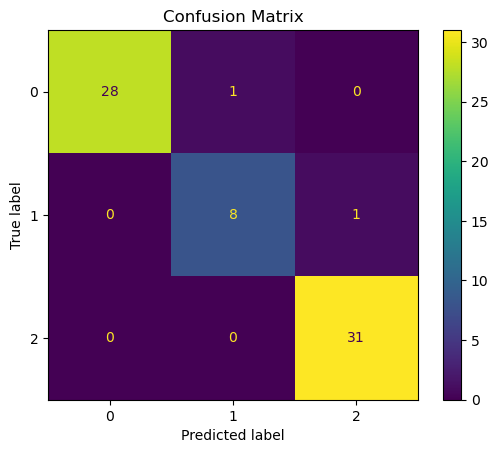

In [80]:
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Confusion matrix:
c_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

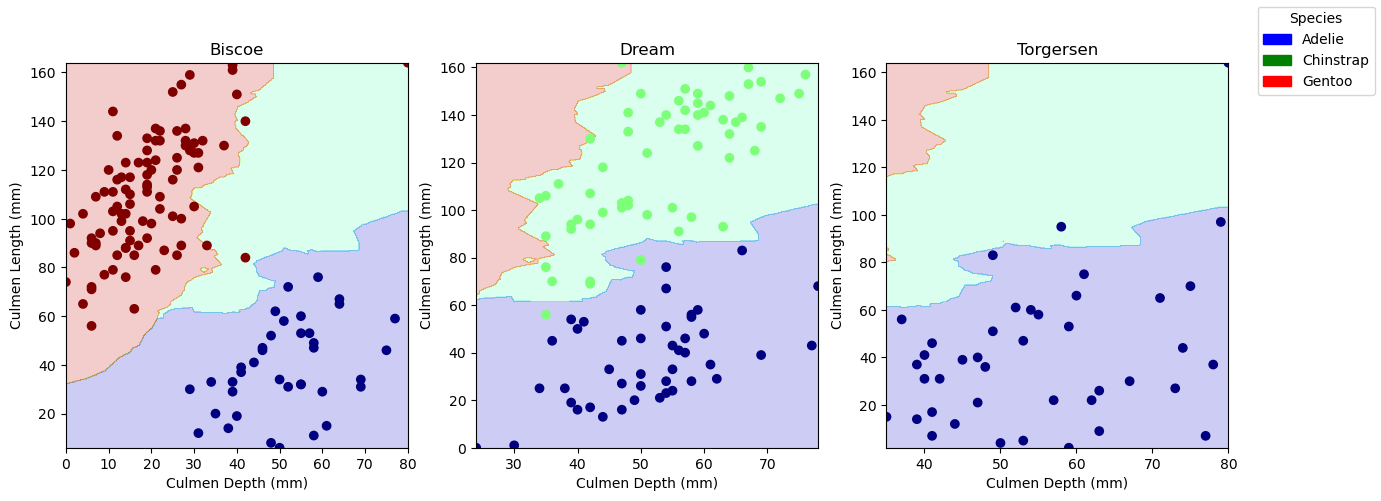

In [82]:
#call to  decision region plot function
plot_regions(knn, X_train, y_train, features)

**Analysis:**

This is a KNN model that calculates K using cross-validation to get the highest accuracy for the model. 

One major issue with KNN is that if classes are not separated well, the model will misclassify points near class boundaries. The decision region plot shows areas where different species overlap.

For example, if two species have similar culmen measurements, KNN will struggle to separate them.
This results in misclassification of samples that lie near decision boundaries.
This is show in hind sight in the illustration of the decision models since almost all of the overlap is right at the borders of the decision regions.

This comes from flaws of the knn model but it also comes from flaws in the feature selection and imperfect data. There will always be outliers and penguins in a species that are irregular compared to the rest and this confuses the model when the case arises.


## Logistic Model

/var/folders/hz/6gc0ty210759pz21t71k8wk80000gn/T/ipykernel_86110/3176428018.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


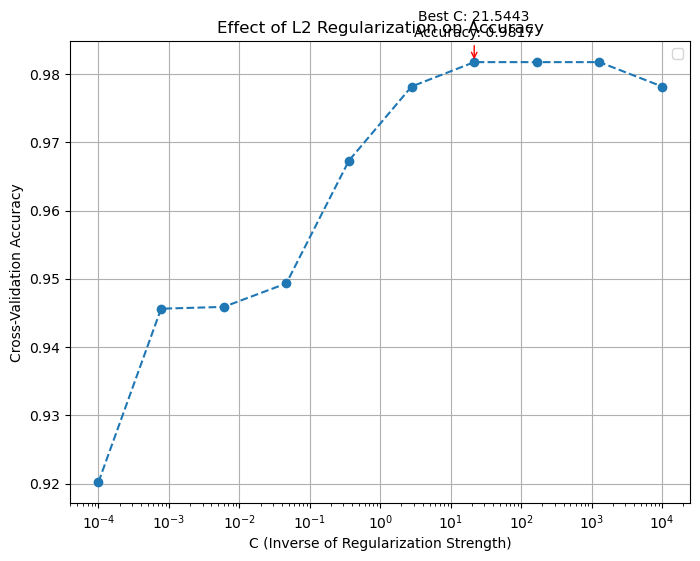

In [89]:
# Logistic Model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Prepare the data - Can be redundant, especially if the data has been prepped in the beginning and be reused thorughout the notebook

# CV values
C_values = np.logspace(-4, 4, 10)

# LR Model
LR = LogisticRegression(penalty = 'l2', solver='lbfgs', max_iter=600)

# Find the best penalty value using GridSearchCV (10-fold cross validation)
param_grid = {'C':C_values}
grid_search = GridSearchCV(LR, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract results
mean_scores = grid_search.cv_results_['mean_test_score']

# Plot C vs Accuracy
plt.figure(figsize=(8, 6))
plt.plot(C_values, mean_scores, marker='o', linestyle='--')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Effect of L2 Regularization on Accuracy')
plt.grid(True)

# Finding the best accuracy point
max_idx = np.argmax(mean_scores)
best_C_value = C_values[max_idx]
best_accuracy = mean_scores[max_idx]

# Annotate the best accuracy point
plt.annotate(f'Best C: {best_C_value:.4f}\nAccuracy: {best_accuracy:.4f}',
             (best_C_value, best_accuracy),
             textcoords="offset points", xytext=(0,18), ha='center', fontsize=10,
             arrowprops=dict(arrowstyle="->", color='red'))

# Show plot
plt.legend()
plt.show()

Accuracy:1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


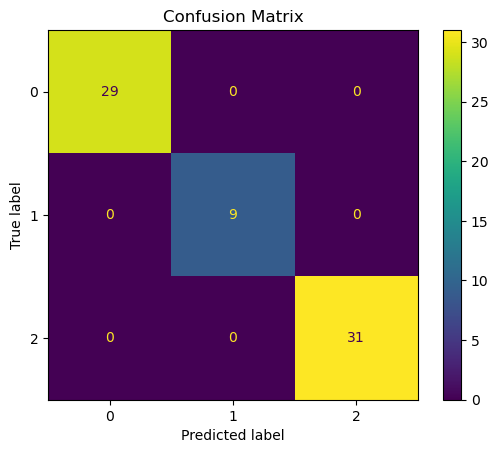

In [91]:
LR = LogisticRegression(multi_class='multinomial', penalty = 'l2', C = best_C_value, solver='lbfgs', max_iter=600)
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy:{accuracy}')

c_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

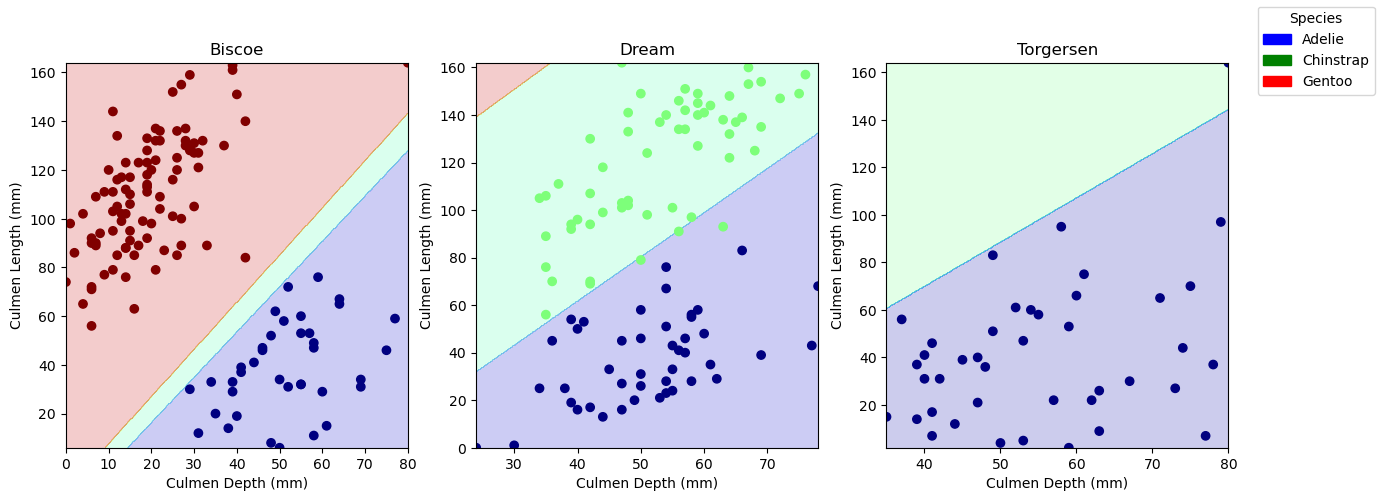

In [93]:
plot_regions(LR, X_train, y_train, features)

**Analysis:**

This is a multinomial logistic regression model. On a high level, logistic regression models use mathematical functions to calculates the probability of each observation falling under each class using a mathematical equation. Unlike binary logistic regression, however, since there are multiple classes, multinomial logistic regression uses the softmax function to calculate each observaton's probability for falling under each class and assign the most probable class.

As reflected by the confusion matrix, the mutilnomial logistic regression model with a cross-validated Ridge penalty coefficient is incredibly accurate with only 1 misclassification, scoring a 98.6% accuracy score.

From the decision region plot, the model is also proved to be really accurate as only one point for Biscoe is misclassified and two for Dream.

Althought this would not classify as a mistake, an area of improvment with the multinomial logistic regression model is the class separation between Adlier and Chinstrap penguins on the Dream island. While the separation is distint enough, it is not the most ideal for logistic regression models, and it would fail when the data set is too small, or if the classes were highly imbalanced. As seen from the decision region plot, it is apparent that the highest number of misclassfication also occcur with the two species on Dream.

A mistake that is present in the model is the assumption that the relationship between the predictors and the log-odds are linear. This is reflected from the decision region plot as all boundaries are straight, signifying a linear relationship. While this assumption is not necesarily violated in this model and feature selection, the model would fail had the relationship between the predictors and the log-odds been non-linear and hence having a non-linear boundary on the decision region plot.

## Random Forest Model 

In [106]:
from sklearn.ensemble import RandomForestClassifier
# Apply function to random forest

rf = RandomForestClassifier()
# 10-fold cross validation

cv_scores = cross_val_score(rf, X_train, y_train, cv = 10)
print(cv_scores, '\n', 'Mean cross validation score: ' + str(cv_scores.mean()))



[0.96428571 1.         1.         1.         0.96428571 0.96296296
 1.         0.96296296 1.         1.        ] 
 Mean cross validation score: 0.9854497354497355


[Text(0.5, 1.0, 'Best Depth: 7'),
 Text(0.5, 0, 'rf depth'),
 Text(0, 0.5, 'CV score')]

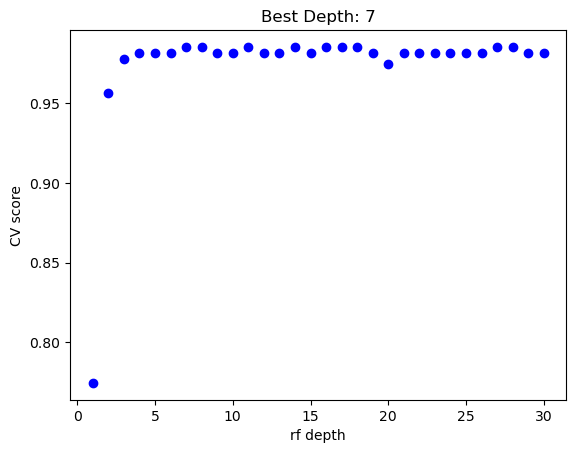

In [108]:
#visualizing 10-fold cross validation and finding optimal max_depth

fig, ax = plt.subplots(1)

best_score = 0
for d in range(1,31):  # assessing between max depth 1 and 30
    rf = RandomForestClassifier(max_depth = d)
    cv_score = cross_val_score(rf, X_train, y_train, cv = 10).mean()
    ax.scatter(d, cv_score, color = 'blue')
    if cv_score > best_score:
        best_depth = d
        best_score = cv_score

ax.set(title = 'Best Depth: ' + str(best_depth), xlabel = 'rf depth', ylabel = 'CV score')


In [116]:
rf = RandomForestClassifier(max_depth=best_depth)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

0.9855072463768116


(69,)


Text(0.5, 0.98, 'Confusion Matrix of species predicted using testing data')

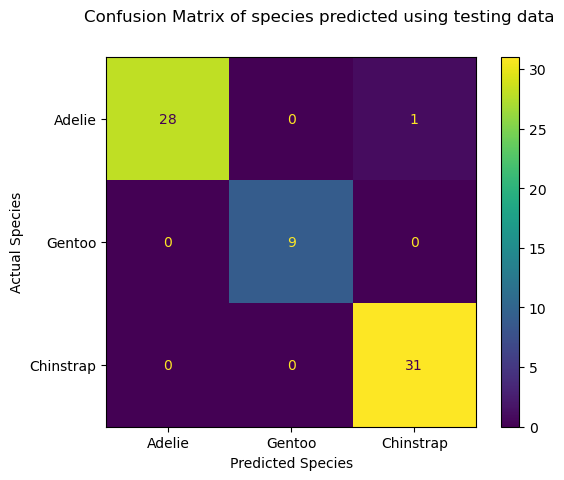

In [122]:
y_test_pred = rf.predict(X_test)
print(y_test_pred.shape)

# map confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels = list(set(penguins['Species'])))
plt.xlabel('Predicted Species')
plt.ylabel('Actual Species')
plt.suptitle('Confusion Matrix of species predicted using testing data')

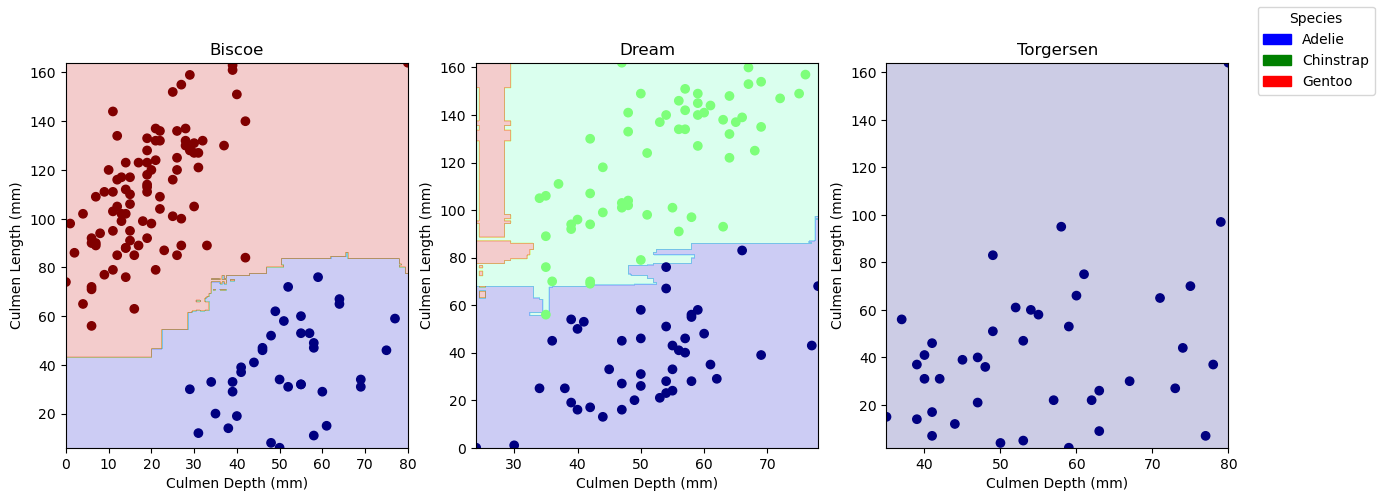

In [124]:
plot_regions(rf, X_train, y_train, features)

**Analysis**

The scores for the model are 1 for training and 0.95 for testing, respectively. The scores are relatively high and the score for training and testing data, which does not imply overfitting nor underfitting. This may be attributable to the fact that the complexity of the model is appropriately chosen through mapping of cross validation scores, which allow for an optimal parameter. Additionally, there may be sufficient differences between the species when it comes to the chosen characteristics, which supported the algorithm in making the distinctions between the species. The scores suggest that Random Forest Classifier's performance in predicting Species using island, culmen depth, and culmen length is quite good. We can use a confusion matrix and decision regions to see how the model's prediction compare to the actual data.

The confusion matrix shows that the model mis-predicts only 1 individual in the testing data set of 68 individuals, which is less than 1% of the testing sample. This reflects the scores estimated by the model. Specifically, the model mis-predicted an Adelie penguin as a Chinstrap. The confusion between Chinstrap and Adelie penguins is likely a result of the ambiguous division of these species shown in the decision region for Dream island. Here, we can see that multiple data points for both species lie on the decision boundary and deviates from the main cluster of their category, suggesting they have very similar range to each other and thus is difficult to detect with the model. Other than that, the model has high accuracy in predicting the species given the chosen variables, and is a fitting algorithm for this purpose.

## Discussion: 
The overall performance of all three models—Multinomial Logistic Regression, K-Nearest Neighbors (KNN), and Random Forest (RF)—demonstrates high accuracy, indicating that the dataset is well-structured for classification. Using the features Culmen Length (mm), Culmen Depth (mm), and Island, the models achieved test set accuracies of 100% for Logistic Regression, 97.1% for KNN, and 98.5% for Random Forest. Given these results, Multinomial Logistic Regression emerges as the best model, as it achieves perfect accuracy while aligning with the observed linear decision boundaries in the data. However, while a 100% accuracy score is impressive, it also suggests that the dataset may be too small or too homogeneous, limiting its ability to generalize to more diverse samples. If additional or different data were available, two key improvements could enhance the model’s robustness. First, implementing Ridge Regression (L2 regularization) in Logistic Regression would help prevent overfitting by penalizing overly confident weight estimates. Though this effect may be minor on the current dataset, it would become more impactful with a larger, more complex dataset. Second, applying feature standardization would ensure that variables with different magnitudes, such as Culmen Length and Depth, do not disproportionately influence the model. Since Logistic Regression is sensitive to feature scaling, standardizing the input data would help maintain stability and consistency, particularly in datasets with higher variability. Overall, while Logistic Regression is the most effective model for the current dataset, future iterations should incorporate regularization and standardization to ensure it remains generalizable and robust as the dataset grows.